In [13]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np
from torchvision.io import read_image
import wandb
from src.data import make_dataset
plt.ion()

In [19]:
wandb.init(project="Bayesian DL", name = 'STN_trial', entity="zefko")

wandb: Currently logged in as: zefko (use `wandb login --relogin` to force relogin)


In [11]:
config = {
    "kernel_size": 5,
    "channels":1,
    "filter_1_out" :16,
    "filter_2_out" :32,
    "padding" :0,
    "stride" :1, 
    "pool":2,
    "learning_rate": 0.01,
    "epochs": 50,
    "batch_size": 64,
    "crop_size":128
}


wandb.config ={
    
    "learning_rate": 0.01,
    "epochs": 50,
    "batch_size": 64}

In [14]:
train_loader,test_loader = make_dataset.data(config["batch_size"],config["crop_size"],misplacement=False)

100.0%


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


102.8%
0.7%


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100.0%


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



112.7%

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


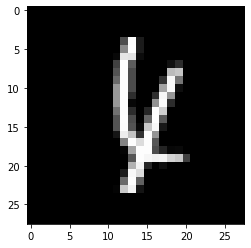

Label: 4


In [15]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[1].squeeze()
label = train_labels[1]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [44]:
preview_dt = wandb.Table(columns=["id", "image", "label", "split"])

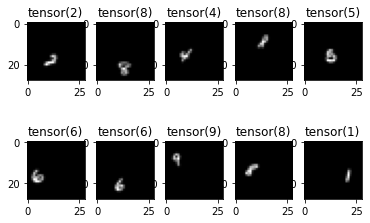

In [53]:
for i in range(10):
    label = train_labels[i]
    plt.subplot(2, 5, i+1)
    plt.imshow(train_features[i][0], cmap='gray')
    plt.title(label)
    #print(f"Label: {label}")
    preview_dt.add_data(i,wandb.Image(train_features[i]),label,'train')
wandb.log({'Train Input':preview_dt})

In [46]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        #self.conv3 = nn.Conv2d(20, 30, kernel_size=5)
        #self.conv3_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50) #original
        #self.fc1 = nn.Linear(16820, 50)
        self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

#apply laplace to the last linera layer for the first attempt
        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),#original
            #nn.Linear(10 * 28* 28, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        #print('x',x.size())
        xs = self.localization(x)

        #print('xs',xs.size())
        xs = xs.view(-1, 10 * 3 * 3) #original
        #xs = xs.view(-1, 10 * 28 * 28)

        #print('xs view',xs.size())
        theta = self.fc_loc(xs)

        #print('theta before view',theta.shape)
        theta = theta.view(-1, 2, 3)
        #print('theta',theta.shape)
        #print('size',x.size())


        grid = F.affine_grid(theta, x.size(),align_corners =True)
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):

        #print('input',x.size())
        # transform the input
        x = self.stn(x)

        #print('transform',x.size())
        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        #print('forward1',x.size())

        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #print('forward2',x.size())

        #x = F.relu(F.max_pool2d(self.conv3_drop(self.conv3(x)), 2))
        #print('forward2+',x.size())

        x = x.view(-1, 320) #original
        #x = x.view(-1, 16820)

        #print('forward3',x.size())

        x = F.relu(self.fc1(x))
        #print('forward4',x.size())

        x = F.dropout(x, training=self.training)
        #print('forward5',x.size())

        x = self.fc2(x)
        #print('forward6',x.size())

        return F.log_softmax(x, dim=1)


model = Net().to(device)

In [47]:
print(model)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (localization): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 10, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
  )
  (fc_loc): Sequential(
    (0): Linear(in_features=90, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=6, bias=True)
  )
)


In [49]:
optimizer = optim.SGD(model.parameters(), lr=0.01)


def train(epoch):
    wandb.watch(model, optimizer,log="all", log_freq=10)
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            wandb.log({"epoch": epoch, "loss": loss.item()})
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [50]:
def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        wandb.log({"test loss": test_loss})

        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

In [12]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

In [51]:
def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2,figsize=(20,20))
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

for epoch in range(1, 100 + 1):
    train(epoch)
    test()

# Visualize the STN transformation on some input batch
visualize_stn()
wandb.log({'Final':wandb.Image(visualize_stn)})

plt.ioff()
plt.show()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning:

Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.



Train Epoch: 1 [0/60000 (0%)]	Loss: 2.306885
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.307741


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning:

size_average and reduce args will be deprecated, please use reduction='sum' instead.




Test set: Average loss: 2.2997, Accuracy: 1439/10000 (14%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.299720
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.300446

Test set: Average loss: 2.2913, Accuracy: 1561/10000 (16%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.287234
Train Epoch: 3 [32000/60000 (53%)]	Loss: 2.284089

Test set: Average loss: 2.2578, Accuracy: 1782/10000 (18%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 2.268181
Train Epoch: 4 [32000/60000 (53%)]	Loss: 2.228454

Test set: Average loss: 2.1956, Accuracy: 1947/10000 (19%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 2.133359
Train Epoch: 5 [32000/60000 (53%)]	Loss: 2.169870

Test set: Average loss: 2.1461, Accuracy: 2096/10000 (21%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 2.171651
Train Epoch: 6 [32000/60000 (53%)]	Loss: 2.113768

Test set: Average loss: 2.0961, Accuracy: 2198/10000 (22%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 2.104756
Train Epoch: 7 [32000/60000 (53%)]	Loss: 2.045749

Test set: Average loss: 2.0208, Accuracy: 2375/10000 (24%)

Tra

KeyboardInterrupt: 

In [55]:
wandb.finish()